#### ΠΡΟΣΟΧΗ:
Τα joblib dumps των τελικών `corpus_tf_idf.pkl` και `som.pkl` δεν περιέχονται στο zip file καθώς είχαν απαγορευτικά μεγάλο μέγεθος. Αυτό ΔΕΝ οφείλεται σε δική μας ελλιπή υλοποίηση, αλλά σε μια ιδιομορφία του corpus που μας αντιστοιχεί και αναγκάζει ορισμένους πίνακες να αντιστοιχίζονται αχρείαστα σε float64. Το πρόβλημα το έχει δει ο κ. Σιόλας, ο οποίος μας έδωσε την άδεια να ανεβάσουμε τα pickles σε ένα drive ώστε να έχετε πρόσβαση σε αυτά. Μας διαβεβαίωσε πως δε θα υπάρξει βαθμολογική ποινή. Τα links των αρχείων:

* `corpus_tf_idf.pkl` : https://drive.google.com/open?id=1q5G1fRPwNBhNUzkWNTAqvAZCzY1B0tJF
* `som.pkl` : https://drive.google.com/open?id=1V5Je-RfpvQyCgm-F5UDGaPD88gXbdad8

Για οποιαδήποτε απορία ή πρόβλημα στα Links επικοινωνήστε μαζί μας. Για το θέμα που προέκυψε μπορείτε να απευθυνείτε στον κ. Σιόλα.

# Neural Networks ECE NTUA Course 2019-20 ~ Team M.B.4
## Lab Assingment #2: Unsupervised Learning (Recommendation System & SOM)

### A. The Team
* Αβραμίδης Κλεάνθης   ~ 03115117
* Κρατημένος Άγγελος   ~ 03115025
* Πανίδης Κωνσταντίνος ~ 03113602

### Requested Imports

In [1]:
import pandas as pd, numpy as np, scipy as sp
import nltk, string, collections
import time, joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

import somoclu, matplotlib
%matplotlib inline

If you installed Somoclu with pip on Windows, this typically means missing DLLs. Please refer to the documentation.


## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με περίπου 40.000 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [2]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής

1. Κάθε ομάδα μπορεί να βρει [εδώ](https://docs.google.com/spreadsheets/d/1oEr3yuPg22lmMeqDjFtWjJRzmGQ8N57YIuV-ZOvy3dM/edit?usp=sharing) τον μοναδικό  αριθμό της "Seed" από 1 έως 78. 

2. Το data frame `df_data_2` έχει 78 γραμμές (ομάδες) και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Στο επόμενο κελί αλλάξτε τη μεταβλητή `team_seed_number` με το Seed της ομάδας σας από το Google Sheet.

4. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [3]:
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 19

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1RRoiOjhD0JB3l4oHNFOmPUqZHDphIdwL"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index] # movie categories in binary form
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=99` (την εκατοστή) θα γράψουμε `print(corpus[99])`.

In [4]:
ID = 99
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

["Confessions d'un Barjo"]
['"Drama",  "Comedy of manners",  "Comedy-drama",  "Domestic Comedy"']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0

# Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο

<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προσθήκη stop words που βρέθηκαν εμπειρικά οτι βελτιώνουν τις συστάσεις

Προστέθηκαν ονόματα και συχνές λέξεις στην περιγραφή ταινιών (πχ plot,story,film) που δεν προσθέτουν αξία στο περιεχόμενο της περιγραφής:

In [5]:
nltk.download("stopwords")

name_file = open("stopwords.txt",'r')
names = [line.split(',') for line in name_file.readlines()]
name_stopwords = names[0]

for i in range(len(name_stopwords)): name_stopwords[i]=name_stopwords[i].strip()
    
movie_words=["story","film","plot","about","movie",'000','mother','father','sister','brother','daughter','son','village'
             '10', '12', '15', '20','00', '01', '02', '04', '05', '06', '07', '08', '09', '100', '1000', '10th', '11', 
             '120', '13', '13th', '14', '14th', '150', '15th', '16', '16th', '17', '18']

my_stopwords = stopwords.words('english') + movie_words + name_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kavra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming & TF-IDF

Προχωρούμε σε περαιτέρω επεξεργασία του corpus μας εστιάζοντας στο stem των λέξεων και αγνοώντας σχετικά λήμματα, προς αύξηση της αποδοτικότητας. Στη συνέχεια κάνουμε τη ζητούμενη μετατροπή σε tf-idf:

In [6]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word: pun.append(letter in string.punctuation)
        if not all(pun): filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    porter_stemmer = PorterStemmer()
    stemmed_words = [porter_stemmer.stem(word) for word in words] 
    return (" ".join(stemmed_words))

In [7]:
# απαραίτητα download για τους stemmer/lemmatizer/tokenizer
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('punkt')

stemmed_corpus = [preprocess_document(corp) for corp in corpus]

vectorizer = TfidfVectorizer(max_df=0.2, min_df=0.01, analyzer='word', stop_words = my_stopwords, ngram_range=(1,1))
corpus_tf_idf = vectorizer.fit_transform(stemmed_corpus).toarray()
print("corpus after tf-idf",corpus_tf_idf.shape)

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kavra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\kavra\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kavra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


corpus after tf-idf (5000, 1810)


['corpus_tf_idf.pkl']

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων που κάναμε έχουν **σημαντική επίδραση στην ποιότητα των συστάσεων, στη διαστατικότητα και τον όγκο των δεδομένων, κατά συνέπεια και στους χρόνους εκπαίδευσης**.

## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα παραδώσετε θα είναι μια συνάρτηση `content_recommender` με δύο ορίσματα `target_movie` και `max_recommendations`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, από το `corpus_tf_idf` υπολογίστε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), id, τίτλο, σύνοψη, κατηγορίες (categories)


In [8]:
def movie_info(movie_id):
    print(*titles[movie_id].flatten(),"~ ID:",movie_id)
    print("Category: ",*categories[movie_id].flatten())

def get_distances(target_movie_id,corpus):
    distances = np.zeros((corpus.shape[0]))
    for i in range(corpus.shape[0]): distances[i]=sp.spatial.distance.cosine(corpus[target_movie_id],corpus[i])
    return distances

def content_recommender(target_movie,max_recomendations):

    distances = get_distances(target_movie,corpus_tf_idf)
    similarity = np.argsort(distances) # similarity = 1-distance
    similarity = similarity[:max_recomendations+1]
    
    for i in similarity:
        if i==target_movie:
            print("Target Movie:",end=" ")
            movie_info(i)
            print("\nRecommendations:\n")
        else: movie_info(i); print()

## Βελτιστοποίηση

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε τη για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. Μπορείτε επίσης να βελτιστοποιήσετε τη συνάρτηση παρατηρώντας πολλά φαινόμενα που το σύστημα εκλαμβάνει ως ομοιότητα περιεχομένου ενώ επί της ουσίας δεν είναι επιθυμητό να συνυπολογίζονται (δείτε σχετικά το [FAQ](https://docs.google.com/document/d/1-E4eQkVnTxa3Jb0HL9OAs11bugYRRZ7RNWpu7yh9G4s/edit?usp=sharing)). Ταυτόχρονα, μια άλλη κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται ποιοτικές επιπτώσεις.

In [9]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')
content_recommender(120,5)

Target Movie: Ride Beyond Vengeance ~ ID: 120
Category:  "Action/Adventure",  "Western",  "Action"

Recommendations:

Full Clip ~ ID: 3045
Category:  "Thriller",  "Action/Adventure",  "Action Thrillers",  "Action"

Forty Guns ~ ID: 283
Category:  "Action/Adventure",  "Western"

One Girl's Confession ~ ID: 1232
Category:  "Crime Fiction",  "Drama",  "Black-and-white",  "Film noir"

The Thief Lord ~ ID: 4274
Category:  "Fantasy Adventure",  "Adventure",  "Children's/Family",  "Fantasy",  "Family Film",  "Family-Oriented Adventure"

Warlock ~ ID: 2174
Category:  "Action/Adventure",  "Western",  "Drama",  "Time travel"



C:\Users\kavra\Anaconda3\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


## Επεξήγηση επιλογών και ποιοτική ερμηνεία

Περιγράψτε πώς προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. Δώστε 10 παραδείγματα (IDs) που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (5 και παραπάνω) και σημειώστε ποια είναι η θεματική που ενώνει τις ταινίες.

### Διαδικασία βελτιστοποίησης
Ακολουθήσαμε την πρόταση της εκφώνησης της εργασίας και ξεκινήσαμε την τροποποίηση των παραμέτρων του TfidfVectorizer αρχικά για 2 προτάσεις, και στην συνέχεια για 5 προτάσεις.
Αρχικά παρατηρήσαμε οτι η παράμετρος max_df του TfidfVectorizer δεν αφαιρούσε περισσότερα features για τιμές άνω του 0.4, και για τιμές χαμηλότερες απο αυτό μείωνε την ποιότητα των προτάσεων. Επίσης η παράμετρος ngram_range δοκιμάστηκε με τιμές (1,1)-only unigrams , (1,2)-unigrams and bigrams , (1,3)-unigrams bigrams and trigrams αλλα δεν επηρέασε θετικά τα αποτελέσματα οπότε αφέθηκε στην τιμη (1,1). Οπότε, η βελτιστοποίηση του TfidfVectorizer έγινε με την τροποποίηση της παραμέτρου min_df και την εισαγωγή stop words  με ταυτόχρονη παρατήρηση των προτάσεων που προκύπτουν. Τα 10 ζητούμενα παραδείγματα:

In [10]:
movie_list = [10,20,21,100,120,222,540,2020,2859,3130]
cats = ["Crime Fiction","Action/Adventure","Drama","Crime Fiction","Adventure",
        "Thriller","Horror","Science Fiction","Drama","Science Fiction"]
for i in range(10):
    content_recommender(movie_list[i],5)
    print("Common category:",cats[i]," -------------------------------------------------------------\n")

Target Movie: Shield for Murder ~ ID: 10
Category:  "Crime Fiction",  "Detective fiction",  "Detective",  "Mystery",  "Drama",  "Film noir"

Recommendations:

It's a Mad, Mad, Mad, Mad World ~ ID: 1753
Category:  "Crime Fiction",  "Ensemble Film",  "Adventure",  "Chase Movie",  "Comedy",  "Family Film",  "Action"

Nerrukku Ner ~ ID: 3065
Category:  "Musical",  "Drama",  "Bollywood",  "World cinema"

The Enforcer ~ ID: 4285
Category:  "Crime Fiction",  "Drama",  "Film noir"

Running Out Of Time ~ ID: 1112
Category:  "Thriller",  "Action/Adventure",  "Action",  "Chinese Movies",  "World cinema"

Filantropica ~ ID: 3216
Category:  "Comedy"

Common category: Crime Fiction  -------------------------------------------------------------

Target Movie: Eagle's Wing ~ ID: 20
Category:  "Action/Adventure",  "Western"

Recommendations:

The Only Good Indian ~ ID: 3749
Category:  "Indie",  "Period piece",  "Action/Adventure",  "Revisionist Western",  "Western",  "Drama"

South Sea Woman ~ ID: 123


# Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM

<img src="https://drive.google.com/uc?export=download&id=1R1R7Ds9UEfhjOY_fk_3wcTjsM0rI4WLl" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 

Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της. Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM.

In [11]:
def build_final_set(doc_limit=5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

In [12]:
final_set = build_final_set()

Τυπώνουμε τις διαστάσεις του τελικού dataset μας. Χωρίς βελτιστοποίηση του TFIDF θα έχουμε περίπου 50.000 χαρακτηριστικά.

In [13]:
final_set.shape

(5000, 2132)

Με βάση την εμπειρία σας στην προετοιμασία των δεδομένων στην επιβλεπόμενη μάθηση, υπάρχει κάποιο βήμα προεπεξεργασίας που θα μπορούσε να εφαρμοστεί σε αυτό το dataset; 




>Θα μπορούσαμε με PCA να μειώσουμε τις διαστάσεις:



In [14]:
pca = PCA(n_components=0.97)
pca_final_set = pca.fit_transform(final_set)
print(pca_final_set.shape)
print("Decrease of components:", round ((1-pca_final_set.shape[1]/final_set.shape[1])*100, 2 ),"%")

(5000, 1233)
Decrease of components: 42.17 %


Παρατηρούμε οτι με διατήρηση 97% της διασποράς των χαρακτηριστικών μπορούμε να μειώσουμε τις διαστάσεις πάνω από 40%.

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

In [ ]:
n_rows, n_columns = 30, 30
som = somoclu.Somoclu(n_columns, n_rows, compactsupport=False)
%time som.train(final_set,epochs=100)

Λόγω του προβλήματος στο training των μοντέλων Somoclu που αναφέρεται στο import του μοντέλου, η εκπαίδευση έγινε στο Colab. Αποθηκεύουμε το προκύπτον μοντέλο και το λαμβάνουμε εδώ:

In [15]:
som = joblib.load("som.pkl")


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [16]:
bmus, indices = np.unique(som.bmus,axis=0,return_index=True)


## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [17]:
som.cluster(KMeans(n_clusters=30))


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [171]:
joblib.dump(som,'som.pkl')

['som.pkl']

## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

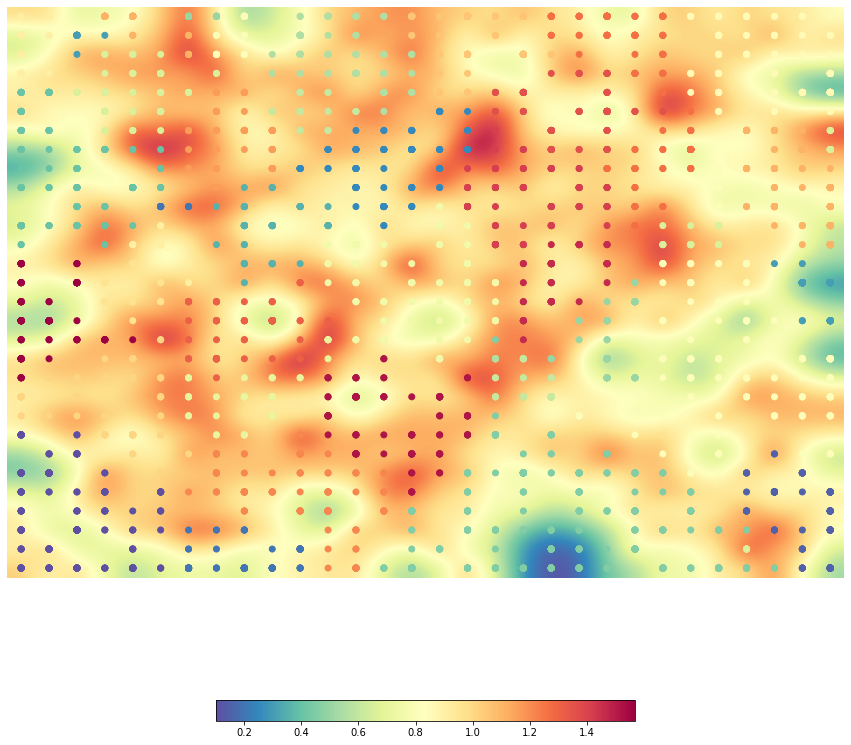

In [18]:
som.view_umatrix(bestmatches=True, colorbar=True,figsize=(15, 15)); matplotlib.pyplot.show()

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

In [19]:
print(som.clusters)

[[16 16  4 20 20 20  8  8 14 14  9  9  9  9 19 19 19 19 19 23 23 23 23 23
  15 15 15 15 15 15]
 [16 16  4  4 20 20 20 14 14  9  9  9  9  9 19 19 19 19 19 23 23 23 23 23
  15 15 15 15 15 15]
 [16 16  4 11 11 11 20 14 14  9  9  9  9  9  9 19 19 19 19 19 23 23 23 23
  15 15 15 15 15 15]
 [16 16 11 11 11 11 11 11 21  9  9  9  9  9  9 19 19 19 19 25 25 25 23 23
  15 15 15 15 15 15]
 [ 6  6 11 11 11 11 11 21 21 10 10 10  9  9  9 19 19 25 25 25 25 25 25 23
  15 15 15 15 15 15]
 [ 6  6 11 11 11 11 11 21 21 10 10 10 10  9  3  3  3 25 25 25 25 25 25 25
  23 14 20 15 15 15]
 [ 6  6  6 11 11 11 21 21 21 21 10 10  3  3  3  3  3 26 25 25 25 25 25 23
  23 14 20 20 20 11]
 [ 6  6  6  6  6  6 21 21 21 21 21  3  3  3  3  3  3 26 26 25 25 25 23 23
  23 23 20 20 20 11]
 [ 6  6  6  6  6  6 21 21 21 21  3  3  3  3  3  3 26 26 26 26 26 23 23 23
  23 14 20 20 20 20]
 [ 6  6  6  6  6  6  6 21  5  5  5  3  3  3  3  3 26 26 26 26 26 26 23 23
  14 14 20 20 20 20]
 [ 6  6  6  6  6  2  2  5  5  5  5  5  3  3  3 13 

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

In [20]:
print("\nClusters sorted by increasing number of neurons: (cluster_index,num_neurons)")
values,counts = np.unique(som.clusters,return_counts=True)
sorted_counts = np.argsort(counts)
print(np.array([list(values[sorted_counts]),list(counts[sorted_counts])]))


Clusters sorted by increasing number of neurons: (cluster_index,num_neurons)
[[17  4  2 16 12 21 27 10  1  8 19 29  5 25 24  9 26  3 11 18 20 15 23 28
  22  6  0 13  7 14]
 [11 15 16 17 19 19 19 19 20 20 21 21 21 24 25 26 27 29 31 32 32 33 33 35
  37 40 41 45 84 88]]


## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

In [21]:
def print_categories_stats(ID_list):
    total_categories = []
    for i in ID_list:
        cat = [category.strip(" ").strip('"') for category in categories[i][0].split(",")]
        total_categories.extend(cat)
    result,counts = np.unique(total_categories,return_counts=True)
    sorted_counts = np.argsort(-counts)
    final = [(result[n],counts[n]) for n in sorted_counts]
    print("Overall Cluster Genres stats:")
    print(final); return 

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

In [22]:
def where_is_same(a,b):
    return np.where(np.all(a==b,axis=1))[0]

def print_cluster_neurons_movies_report(cluster):
    cluster_bmus = np.column_stack(np.where(som.clusters==cluster)[::-1])
    li = [indices[where_is_same(bmu,bmus)] for bmu in cluster_bmus if bmu in bmus]
    li = [ind[0] for ind in li if len(ind)]
    return cluster_bmus

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

In [23]:
def neuron_movies_report(neurons):
    id_list = []
    index = [where_is_same(som.bmus,neuron) for neuron in neurons]
    index = [list(i) for i in index if len(i)]
    for i in index: id_list += i
    return id_list

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες. Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμό ενός cluster που μας ενδιαφέρει. Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [37]:
cluster = 7
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
print_categories_stats(id_list)

Overall Cluster Genres stats:
[('Drama', 728), ('War film', 54), ('Family Film', 43), ('Action', 42), ('Comedy film', 35), ('Adventure', 30), ('Fantasy', 24), ('Family Drama', 22), ('Film adaptation', 20), ('Historical fiction', 19), ('Melodrama', 19), ('Musical', 19), ('Short Film', 18), ('Sports', 16), ('Docudrama', 13), ('Chinese Movies', 13), ('Romance Film', 12), ('Science Fiction', 11), ('Western', 10), ('Political drama', 10), ('Coming of age', 10), ('Comedy-drama', 10), ('Biography', 10), ('Japanese Movies', 9), ('Romantic drama', 9), ('Biographical film', 9), ('History', 8), ('Teen', 8), ('Mystery', 8), ('Horror', 8), ('Silent film', 7), ('Documentary', 7), ('Music', 7), ('Black comedy', 6), ('Satire', 6), ('Art film', 6), ('Combat Films', 5), ('Historical drama', 5), ('Christian film', 5), ("Children's/Family", 5), ('Marriage Drama', 5), ('Costume drama', 4), ('Spy', 4), ('Prison', 4), ('Black-and-white', 4), ("Children's", 4), ('Courtroom Drama', 4), ('Ensemble Film', 3), ('

Βλέπουμε πως το 7ο cluster συγκεντρώνει κυρίως ταινίες δράματος, με τις υπόλοιπες κατηγορίες να είναι αρκετά σπανιότερες.


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook (η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας).

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. *Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.*

In [26]:
def categories_in_neuron(neuron):
    ID_list = neuron_movies_report([neuron])
    total_categories = []
    for i in ID_list:
        cat = [category.strip(" ").strip('"') for category in categories[i][0].split(",")]
        total_categories.extend(cat)
    result = np.unique(total_categories)
    sorted_counts = np.argsort(counts)
    return result

categories_in_neurons = np.asarray([categories_in_neuron(i) for i in range(20)])

def number_of_neurons_in_category(category):
    i=0
    for c in categories_in_neurons:
        if category in c: i+=1
    return i

In [27]:
# list of all categories 
distinct_categories=[]
for i in range(5000):
    cat = [category.strip(" ").strip('"') for category in categories[i][0].split(",")]
    distinct_categories.extend(cat)
distinct_categories=np.asarray(distinct_categories)
distinct_categories=np.unique(distinct_categories)


# all categories and their number of neurons 
ncategories=[]
for c in distinct_categories:
    k=number_of_neurons_in_category(c)
    ncategories.append([c,k])

ncategories=np.asarray(ncategories)
sorted_indices = np.argsort(ncategories[:,1])
ncategories = ncategories[sorted_indices]
print("Most popular categories and their number of neurons:\n", ncategories[::-1][:5])
print("\nLeast popular categories and their number of neurons:\n", ncategories[::-1][-5:])

Most popular categories and their number of neurons:
 [['Crime Fiction' '9']
 ['Action' '7']
 ['Drama' '7']
 ['World cinema' '5']
 ['Family Film' '5']]

Least popular categories and their number of neurons:
 [['Law & Crime' '0']
 ['Language & Literature' '0']
 ['Kitchen sink realism' '0']
 ['Kafkaesque' '0']
 ['Hagiography' '0']]


C:\Users\kavra\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  app.launch_new_instance()


Είναι εμφανές πως οι περισσότερο συχνές και οικείες κατηγορίες έχουν αντιστοιχηθεί σε μεγαλύτερο αριθμό νευρώνων.

2. *Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.*

In [38]:
cluster = 16
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
print_categories_stats(id_list)

Overall Cluster Genres stats:
[('Comedy', 124), ('Black-and-white', 106), ('Short Film', 73), ('Musical', 32), ('Slapstick', 21), ('Silent film', 21), ('Indie', 19), ('Family Film', 10), ('Satire', 7), ('Screwball comedy', 5), ('Romance Film', 3), ('Comedy of Errors', 3), ('Parody', 3), ('Science Fiction', 3), ('Teen', 2), ('Road movie', 2), ('Musical comedy', 2), ('Western', 2), ('Workplace Comedy', 2), ('Fantasy', 2), ('World cinema', 2), ("Children's/Family", 2), ('Adventure', 2), ('Family-Oriented Adventure', 2), ('Action', 1), ('War film', 1), ('Thriller', 1), ('Spy', 1), ('Slice of life story', 1), ('Adventure Comedy', 1), ('Animal Picture', 1), ('Animation', 1), ('Black comedy', 1), ('Buddy film', 1), ('Fantasy Comedy', 1), ('Comedy of manners', 1), ('Remake', 1), ('Comedy-drama', 1), ('Operetta', 1), ('Cult', 1), ('Documentary', 1), ('Mondo film', 1), ('Melodrama', 1), ('Drama', 1), ('Horror', 1), ('Comedy Western', 1), ('Absurdism', 1)]


Βλέπουμε πως για τα δύο μακρινά clusters 7, 16 όπως φαίνεται στον παραπάνω πίνακα των clusters, το είδος των ταινιών που αντιπροσωπεύεται διαφέρει σημαντικά (δράμα και κωμωδία).

3. *Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.*

In [39]:
cluster = 11
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
print_categories_stats(id_list)

Overall Cluster Genres stats:
[('Family Film', 137), ('Comedy', 88), ('Adventure', 76), ("Children's/Family", 60), ('Fantasy', 52), ('Animation', 40), ('Family-Oriented Adventure', 24), ("Children's", 21), ('Drama', 20), ("Children's Fantasy", 19), ('Science Fiction', 19), ('Musical', 11), ('Romance Film', 10), ('Computer Animation', 9), ('Fantasy Adventure', 9), ('Family Drama', 7), ('Coming of age', 7), ('Action', 7), ('Japanese Movies', 7), ('Mystery', 6), ('Animal Picture', 6), ('Slapstick', 6), ('Television movie', 6), ('Christmas movie', 6), ('Teen', 5), ('Fantasy Comedy', 5), ('Fairy tale', 5), ('Animated Musical', 5), ('Costume drama', 4), ('Holiday Film', 4), ('Domestic Comedy', 4), ('Sports', 4), ('Music', 3), ('Buddy film', 3), ('Sci-Fi Adventure', 3), ('Short Film', 3), ('Christian film', 3), ('Adventure Comedy', 3), ('Action/Adventure', 3), ('Thriller', 3), ('Creature Film', 3), ('Childhood Drama', 3), ('Romantic comedy', 2), ('Animated cartoon', 2), ('Road movie', 2), ('P

Παρατηρούμε όντως πως το cluster 11 που είναι γειτονικό του 16 έχει επίσης κλίση προς τηνκατηγορία "Κωμωδία" ενώ διευρύνει το είδος και προς τη συγγενή κατηγορία των οικογνειακών ταινιών. Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας. Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά.

*Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες. Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας και σχολιάστε:*

In [40]:
cluster = 14
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
print_categories_stats(id_list)

Overall Cluster Genres stats:
[('Documentary', 104), ('Comedy film', 86), ('Action', 68), ('Romance Film', 61), ('Silent film', 41), ('Musical', 32), ('Adventure', 26), ('Family Film', 26), ('Fantasy', 25), ('Chinese Movies', 21), ('Culture & Society', 20), ('War film', 19), ('Western', 17), ('World cinema', 16), ('Biography', 15), ('Indie', 14), ('Music', 14), ('Romantic comedy', 14), ("Children's/Family", 14), ('Bollywood', 13), ('Historical fiction', 10), ('History', 9), ('Rockumentary', 9), ('Martial Arts Film', 9), ('Political cinema', 8), ('Animation', 7), ('Sports', 7), ('Comedy-drama', 7), ('Social issues', 7), ('Science Fiction', 6), ('Romantic drama', 6), ('Historical drama', 6), ('Filipino Movies', 5), ('Experimental film', 5), ('Avant-garde', 5), ('Television movie', 4), ('Black-and-white', 4), ('Art film', 4), ("Children's Fantasy", 4), ('Wuxia', 3), ('Epic', 3), ('Spaghetti Western', 3), ('Period piece', 3), ('Action/Adventure', 3), ('Tragedy', 3), ('Crime Fiction', 3), (

Παραπάνω έχουμε ένα παράδειγμα cluster (14) κατηγοριών κυρίως Ντοκιμαντέρ και κωμωδίες που δεν έχουν τόση σχέση με "Δράμα" ενώ βρίσκονται γειτονικά στον αντίστοιχο χάρτη (7). Η ερμηνεία που δίνουμε για την τοπολογική τους συνάφεια είναι η δευτερεύουσα παρουσία ταινιών "Action", "Family" και στα 2 cluster που γεφυρώνει το χάσμα τους. Σύμφωνα με την ερώτηση 1, ένα ενδιαφέρον cluster για εμάς θα ήταν αυτό που αντιπροσωπεύει το "Crime fiction". Με inspection επιβεβαιώσαμε πως πρόκειται για τo cluster 27 που ωστόσο δεν έχει απόλυτη τοπολογική συνάφεια με τη γειτονιά του, ούτε μεγάλη έκταση. Εκτιμούμε πως αυτό οφείλεται στην ιδιότητα του είδους να υπάγεται σε μεγαλύτερες κατηγορίες όπως Drama, Thriller κλπ, κατηγορίες που είναι τοπολογικά κοντινές στα συγκεκριμένα clusters.

In [51]:
cluster = 27
cluster_neurons = print_cluster_neurons_movies_report(cluster)
id_list = neuron_movies_report(cluster_neurons)
print_categories_stats(id_list)

Overall Cluster Genres stats:
[('Crime Fiction', 57), ('Thriller', 22), ('Mystery', 20), ('Comedy film', 6), ('Crime Thriller', 6), ('Adventure', 5), ('Romance Film', 4), ('World cinema', 3), ('Television movie', 3), ('Crime Drama', 3), ('Detective', 3), ('Detective fiction', 3), ('Film noir', 3), ('Science Fiction', 2), ('Musical', 2), ('Fantasy', 2), ('Comedy', 2), ('Chinese Movies', 2), ('Whodunit', 2), ('Escape Film', 1), ('Gangster Film', 1), ('Horror', 1), ('Creature Film', 1), ('Natural horror films', 1), ('Prison', 1), ('Sci-Fi Horror', 1), ('Bollywood', 1), ('Superhero', 1), ('Superhero movie', 1), ('Black-and-white', 1), ('Black comedy', 1), ('Action/Adventure', 1)]


## Παράδοση Άσκησης

Στο zip file περιέχονται, εκτός από το παρόν notebook, ο κώδικας σε .py script καθώς και το αρχείο `stopwords.txt` που απαιτήθηκε κατά τη βελτιστοποίηση του tf-idf. Επίσης, παραδίδουμε και μια HTML μορφή του notebook καθώς πιθανότατα σε επόμενο τρέξιμο του clustering, τα νέα clusters που θα προκύψουν να μην ανταποκρίνονται σε αυτό που περιγράφουμε στην αναφορά.